In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [7]:
# 📌 Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf

# 📌 Step 2: Load Dataset
df = pd.read_csv("/kaggle/input/network-traffic-anomaly-detection-dataset/embedded_system_network_security_dataset.csv")

# 📌 Step 3: Preprocessing
# Drop rows with missing labels
df = df.dropna(subset=['label'])

# Convert label values to float
df['label'] = df['label'].astype(float)

# Debug: Check label distribution
print("Unique labels:", df['label'].unique())

# Encode categorical features except 'label'
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label'].apply(lambda x: 0 if x == 0.0 else 1)  # 0 = normal, 1 = anomaly

# Check for normal samples
if sum(y == 0) == 0:
    raise ValueError("No 'normal' samples found. Please check label values.")

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Select only normal data for training
X_normal = X_scaled[y == 0]
print(f"Training samples (normal only): {X_normal.shape[0]}")

# 📌 Step 4: Define Autoencoder Model
input_dim = X_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 📌 Step 5: Train Model
autoencoder.fit(X_normal, X_normal, epochs=20, batch_size=32, validation_split=0.2, shuffle=True)

# 📌 Step 6: Predict & Evaluate
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)

# Define threshold using 95th percentile of normal MSE
threshold = np.percentile(mse[y == 0], 95)
print("Anomaly Threshold:", threshold)

# Predict anomalies
predicted = (mse > threshold).astype(int)

# 📌 Step 7: Evaluation
from sklearn.metrics import classification_report, confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y, predicted))
print("Classification Report:")
print(classification_report(y, predicted))

# 📌 Step 8: Convert to .tflite (TinyML format)
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # quantize
tflite_model = converter.convert()

# Save model
with open("anomaly_detector.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ TFLite model saved successfully for TinyML deployment.")


Unique labels: [0. 1.]
Training samples (normal only): 900
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1931 - val_loss: 0.1851
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1863 - val_loss: 0.1783
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1779 - val_loss: 0.1694
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1694 - val_loss: 0.1599
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1589 - val_loss: 0.1522
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1535 - val_loss: 0.1460
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1477 - val_loss: 0.1401
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1393 - val_loss: 0.1340
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1335 - val_loss: 0.1277
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1272 - val_loss: 0.1212
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1220 - val_loss: 0.1153
Epoch 12/20
23

W0000 00:00:1754327667.089575      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1754327667.089624      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1754327667.096967      36 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


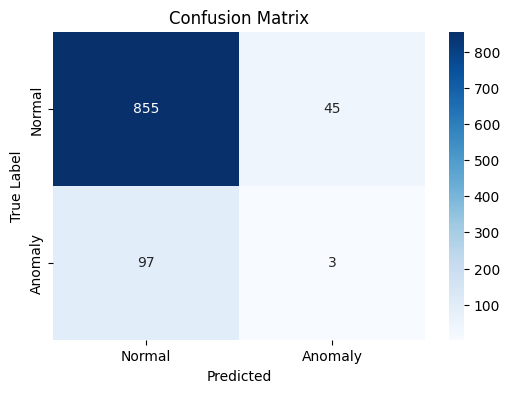

In [9]:
#Confusion metrics

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(y, predicted)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


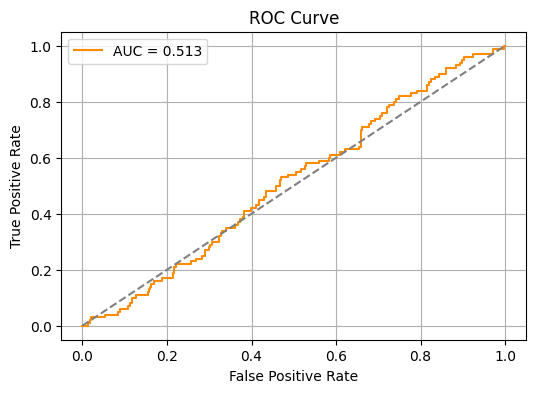

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC curve
fpr, tpr, thresholds = roc_curve(y, mse)
auc_score = roc_auc_score(y, mse)

# Plot ROC
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


Unique labels: [0. 1.]
Training samples (normal only): 900
Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.1906 - val_loss: 0.1847
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1857 - val_loss: 0.1788
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1793 - val_loss: 0.1696
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1684 - val_loss: 0.1568
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1560 - val_loss: 0.1438
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1433 - val_loss: 0.1355
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1365 - val_loss: 0.1293
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1306 - val_loss: 0.1231
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1245 - val_loss: 0.1170
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1199 - val_loss: 0.1109
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1138 - val_loss: 0.1053
Epoch 12/20
23

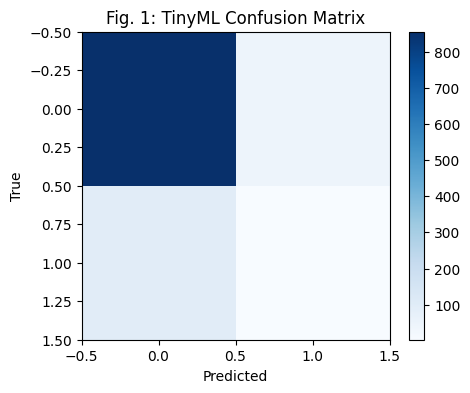

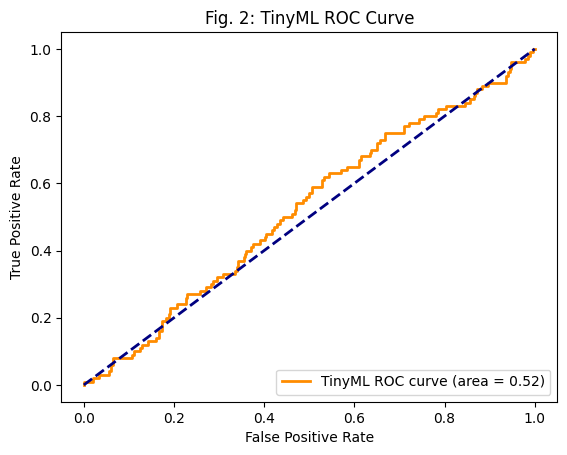

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


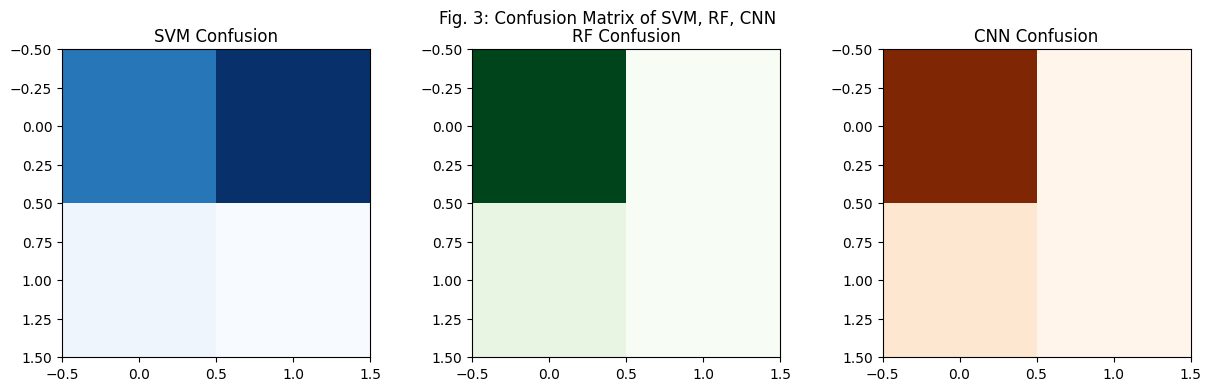

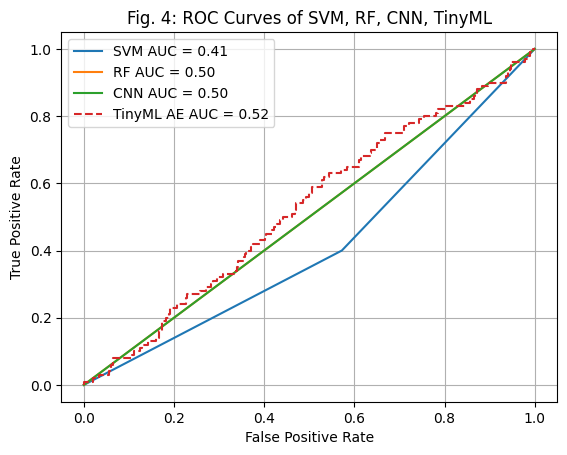


Table 1: Model Comparison (F1-score)
TinyML Autoencoder F1: 0.04054054054054054
SVM F1: 0.12213740458015267
RF F1: 0.0
CNN F1: 0.0
Saved artifact at '/tmp/tmpazbbnlor'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 17), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 17), dtype=tf.float32, name=None)
Captures:
  139248276468944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139248276470672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139248276469520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139248276471440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139248276471632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139248276469712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139248276470864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139247267464592: TensorSpec(shape=(), dtype=tf.resource, name=None)

✅ TFLite model saved success

W0000 00:00:1754329050.275401      36 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1754329050.275442      36 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [12]:
# 📌 Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

# 📌 Step 2: Load Dataset
df = pd.read_csv("/kaggle/input/network-traffic-anomaly-detection-dataset/embedded_system_network_security_dataset.csv")

# 📌 Step 3: Preprocessing
# Drop rows with missing labels
df = df.dropna(subset=['label'])

# Convert label values to float
df['label'] = df['label'].astype(float)

# Debug: Check label distribution
print("Unique labels:", df['label'].unique())

# Encode categorical features except 'label'
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separate features and labels
X = df.drop(columns=['label'])
y = df['label'].apply(lambda x: 0 if x == 0.0 else 1)  # 0 = normal, 1 = anomaly

# Check for normal samples
if sum(y == 0) == 0:
    raise ValueError("No 'normal' samples found. Please check label values.")

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Select only normal data for training
X_normal = X_scaled[y == 0]
print(f"Training samples (normal only): {X_normal.shape[0]}")

# 📌 Step 4: Define Autoencoder Model
input_dim = X_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# 📌 Step 5: Train Model
autoencoder.fit(X_normal, X_normal, epochs=20, batch_size=32, validation_split=0.2, shuffle=True)

# 📌 Step 6: Predict & Evaluate
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)
threshold = np.percentile(mse[y == 0], 95)
predicted = (mse > threshold).astype(int)

# 📌 Step 7: Evaluation (Confusion Matrix + ROC)
print("Confusion Matrix:")
print(confusion_matrix(y, predicted))
print("Classification Report:")
print(classification_report(y, predicted))

# Fig. 1 TinyML Confusion Matrix
plt.figure(figsize=(5,4))
cm = confusion_matrix(y, predicted)
plt.imshow(cm, cmap='Blues')
plt.title("Fig. 1: TinyML Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Fig. 2 TinyML ROC Curve
fpr, tpr, _ = roc_curve(y, mse)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='TinyML ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("Fig. 2: TinyML ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# 📌 Step 8: Comparison Models
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y)

# SVM
svm = OneClassSVM(gamma='auto')
svm.fit(X_train[y_train==0])
pred_svm = svm.predict(X_test)
pred_svm = np.where(pred_svm == -1, 1, 0)

# RF
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_test)

# CNN
cnn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
pred_cnn = (cnn.predict(X_test) > 0.5).astype(int).flatten()

# 📌 Evaluation for other models
# Fig. 3 Confusion Matrix
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].imshow(confusion_matrix(y_test, pred_svm), cmap='Blues')
axs[0].set_title("SVM Confusion")
axs[1].imshow(confusion_matrix(y_test, pred_rf), cmap='Greens')
axs[1].set_title("RF Confusion")
axs[2].imshow(confusion_matrix(y_test, pred_cnn), cmap='Oranges')
axs[2].set_title("CNN Confusion")
plt.suptitle("Fig. 3: Confusion Matrix of SVM, RF, CNN")
plt.show()

# Fig. 4 ROC Curve for All
fpr_svm, tpr_svm, _ = roc_curve(y_test, pred_svm)
fpr_rf, tpr_rf, _ = roc_curve(y_test, pred_rf)
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, pred_cnn)
plt.plot(fpr_svm, tpr_svm, label="SVM AUC = %.2f" % auc(fpr_svm, tpr_svm))
plt.plot(fpr_rf, tpr_rf, label="RF AUC = %.2f" % auc(fpr_rf, tpr_rf))
plt.plot(fpr_cnn, tpr_cnn, label="CNN AUC = %.2f" % auc(fpr_cnn, tpr_cnn))
plt.plot(fpr, tpr, '--', label="TinyML AE AUC = %.2f" % roc_auc)
plt.legend()
plt.title("Fig. 4: ROC Curves of SVM, RF, CNN, TinyML")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()

# 📌 Table 1: Simple Print Comparison
print("\nTable 1: Model Comparison (F1-score)")
from sklearn.metrics import f1_score
print("TinyML Autoencoder F1:", f1_score(y, predicted))
print("SVM F1:", f1_score(y_test, pred_svm))
print("RF F1:", f1_score(y_test, pred_rf))
print("CNN F1:", f1_score(y_test, pred_cnn))

# 📌 Step 9: Convert to .tflite (TinyML format)
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # quantize
tflite_model = converter.convert()

with open("anomaly_detector.tflite", "wb") as f:
    f.write(tflite_model)
print("\n✅ TFLite model saved successfully for TinyML deployment.")
